# Set up

In [1]:
import sys
print(sys.executable)

/Users/mko4003/miniconda3/envs/xgb/bin/python


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import xgboost as xgb
import matplotlib.pyplot as plt

In [53]:
pd.options.display.max_columns = 50

# Data processing

In [28]:
### looks like main transaction data but smaller sample
# sample_data = pd.read_csv(f'{main_path}/User0_credit_card_transactions.csv')

In [3]:
# File loading
main_path = '/Users/mko4003/Documents/coding projects/credit_card_fraud'
transactions = pd.read_csv(f'{main_path}/credit_card_transactions-ibm_v2.csv')
# user_meta = pd.read_csv(f'{main_path}/sd254_users.csv')
# card_info = pd.read_csv(f'{main_path}/sd254_cards.csv')

# Converting dollar amounts to floats
transactions['Amount'] = transactions['Amount'].astype(str).str.replace('[$,]', '', regex=True).astype(float)

# Combining date columns into 1 column
transactions['date'] = pd.to_datetime(transactions[['Year', 'Month', 'Day']])

# Renaming columns
transactions = transactions.rename(columns={'Is Fraud?': 'fraud'})
transactions.columns = transactions.columns.str.lower()

# Mapping columns
transactions['fraud'] = transactions['fraud'].map({'No': 0, 'Yes': 1})

# Adding transaction id per user
transactions['transaction_id'] = transactions.groupby('User').cumcount()

In [ ]:
# transactions['time'] = pd.to_datetime(transactions['time'])

# User Features

In [33]:
# Creating user specific features
user_features = transactions.groupby('user').agg({
    'amount': ['mean', 'std', 'min', 'max'],
    'transaction_id': 'count',  # Transaction frequency
    'merchant city': lambda x: x.nunique()  # Number of unique locations
}).reset_index()

# Relabelling feature data
user_features.columns = ['user', 'user_avg_amt', 'user_std_amt', 
                      'user_min_amt', 'user_max_amt', 'user_tx_count', 
                      'user_merchant_count']

# Merging back with all transaction information
transactions = transactions.merge(user_features, on='user', how='left')

In [41]:
transactions['amount_deviation_from_user_avg'] = (transactions['amount'] - transactions['user_avg_amt']) / (transactions['user_std_amt'] + 1e-5)

# Model training

In [51]:
split_date = transactions['date'].quantile(0.8)
train_df = transactions[transactions['date'] < split_date]
test_df = transactions[transactions['date'] >= split_date]

In [72]:
feature_cols = ['amount', 'user_avg_amt', 'user_std_amt', 
                'user_tx_count', 'user_merchant_count', 
                'amount_deviation_from_user_avg']

In [73]:
# X_train = train_df.drop(['year', 'month', 'day', 'time', 'errors'], axis=1)
# X_test = test_df.drop(['year', 'month', 'day', 'time', 'errors'], axis=1)

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = train_df['fraud']
y_test = test_df['fraud']

In [74]:
fraud_ratio = (y_train == 0).sum() / (y_train == 1).sum()

In [75]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=fraud_ratio,
    random_state=42,
    eval_metric='aucpr'
)

In [76]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-aucpr:0.00274
[1]	validation_0-aucpr:0.00285
[2]	validation_0-aucpr:0.00289
[3]	validation_0-aucpr:0.00291
[4]	validation_0-aucpr:0.00296
[5]	validation_0-aucpr:0.00293
[6]	validation_0-aucpr:0.00295
[7]	validation_0-aucpr:0.00296
[8]	validation_0-aucpr:0.00305
[9]	validation_0-aucpr:0.00306
[10]	validation_0-aucpr:0.00313
[11]	validation_0-aucpr:0.00312
[12]	validation_0-aucpr:0.00313
[13]	validation_0-aucpr:0.00313
[14]	validation_0-aucpr:0.00312
[15]	validation_0-aucpr:0.00313
[16]	validation_0-aucpr:0.00313
[17]	validation_0-aucpr:0.00312
[18]	validation_0-aucpr:0.00315
[19]	validation_0-aucpr:0.00314
[20]	validation_0-aucpr:0.00314
[21]	validation_0-aucpr:0.00314
[22]	validation_0-aucpr:0.00314
[23]	validation_0-aucpr:0.00314
[24]	validation_0-aucpr:0.00314
[25]	validation_0-aucpr:0.00318
[26]	validation_0-aucpr:0.00318
[27]	validation_0-aucpr:0.00318
[28]	validation_0-aucpr:0.00319
[29]	validation_0-aucpr:0.00318
[30]	validation_0-aucpr:0.00323
[31]	validation_0-

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [77]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

In [78]:
print(f"Overall AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred))

Overall AUC: 0.6910
              precision    recall  f1-score   support

           0       1.00      0.40      0.57   4873944
           1       0.00      0.81      0.00      4833

    accuracy                           0.40   4878777
   macro avg       0.50      0.61      0.29   4878777
weighted avg       1.00      0.40      0.57   4878777



# Assessing feature imporatance


Top 10 Most Important Features:
                          feature  importance
0                          amount    0.358292
5  amount_deviation_from_user_avg    0.262321
3                   user_tx_count    0.116743
2                    user_std_amt    0.103418
1                    user_avg_amt    0.081929
4             user_merchant_count    0.077298


<Figure size 1000x600 with 0 Axes>

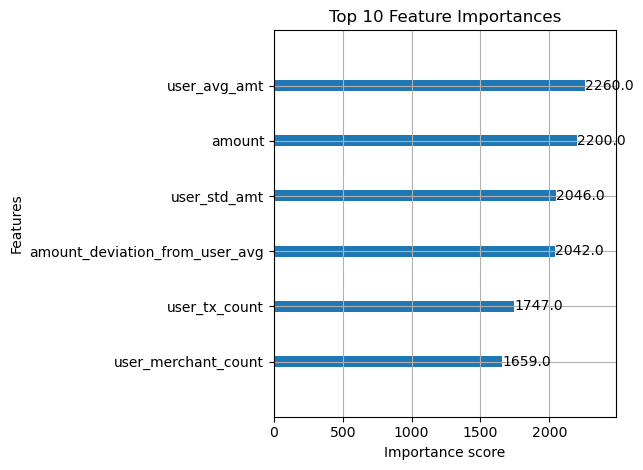

In [80]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# CONTINUE FEATURE DEVELOPMENT

In [39]:
# Create deviation features (key for fraud detection!)

df['is_new_location'] = df.groupby('user_id')['location'].transform(lambda x: ~x.isin(x.value_counts().head(5).index))
df['is_new_merchant'] = df.groupby('user_id')['merchant_id'].transform(lambda x: ~x.isin(x.value_counts().head(10).index))

# Time-based features
df['hour_of_day'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek

# User's typical transaction times
user_typical_hours = df.groupby('user_id')['hour_of_day'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean())
df = df.merge(user_typical_hours.rename('user_typical_hour'), on='user_id', how='left')
df['hour_deviation_from_typical'] = abs(df['hour_of_day'] - df['user_typical_hour'])

# Velocity features (transactions in last N hours)
df = df.sort_values(['user_id', 'timestamp'])
df['transactions_last_hour'] = df.groupby('user_id').rolling('1H', on='timestamp').count()['transaction_id'].values
df['transactions_last_24h'] = df.groupby('user_id').rolling('24H', on='timestamp').count()['transaction_id'].values
df['amount_last_24h'] = df.groupby('user_id').rolling('24H', on='timestamp')['amount'].sum().values

NameError: name 'df' is not defined